In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

In [2]:
data = loadmat('YaleB_32x32.mat')

### **Part 2: kNN**

#### **2.1 : Training and Testing**

#### 1. Error vs Training set size

In [3]:
from sklearn.neighbors import KNeighborsClassifier

# Train-test split 
splits = [10,20,30,40,50]
errors_splits = []

for m in splits:
    train = []
    test = []
    for i in range(1,39):
        indices = np.where(data['gnd'] == i)[0]
        np.random.shuffle(indices)
        train.extend(indices[:m])
        test.extend(indices[m:])
    train = np.array(train)
    test = np.array(test)

    X_train = data['fea'][train]
    X_test = data['fea'][test]
    Y_train = data['gnd'][train].ravel()
    Y_test = data['gnd'][test].ravel()

    # KNN
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accuracy = np.mean(Y_pred == Y_test)
    error = (1 - accuracy)*100
    errors_splits.append(error)


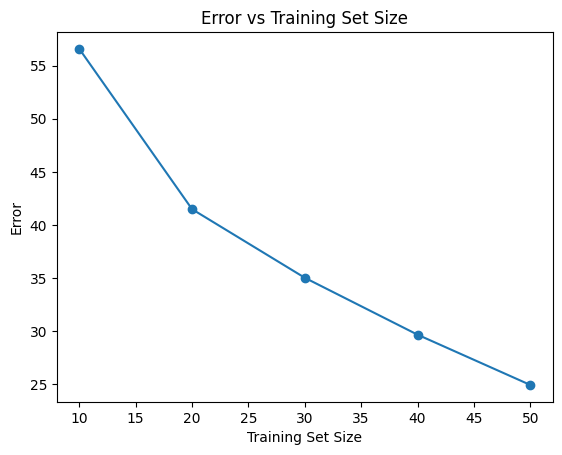

In [4]:
#Plotting the error 

plt.plot(splits, errors_splits, 'o-')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Error vs Training Set Size')
plt.show()


#### 2. Finding the best k

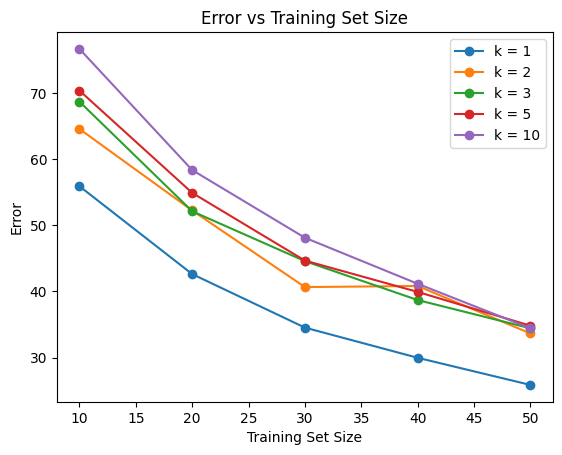

In [5]:
#Repeating for k = 2, 3, 5, 10

k_values = [1,2,3,5,10]
splits = [10,20,30,40,50]
errors_splits_ks = []

for k in k_values:
    for m in splits:
        train = []
        test = []
        for i in range(1,39):
            indices = np.where(data['gnd'] == i)[0]
            np.random.shuffle(indices)
            train.extend(indices[:m])
            test.extend(indices[m:])
        train = np.array(train)
        test = np.array(test)

        X_train = data['fea'][train]
        X_test = data['fea'][test]
        Y_train = data['gnd'][train].ravel()
        Y_test = data['gnd'][test].ravel()

        # KNN
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, Y_train)
        Y_pred = knn.predict(X_test)
        accuracy = np.mean(Y_pred == Y_test)
        error = (1 - accuracy)*100
        errors_splits_ks.append(error)

    plt.plot(splits, errors_splits_ks, label = 'k = ' + str(k), marker = 'o')
    errors_splits_ks = []

plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Error vs Training Set Size')
plt.legend()
plt.show()


Error:  33.202511773940344


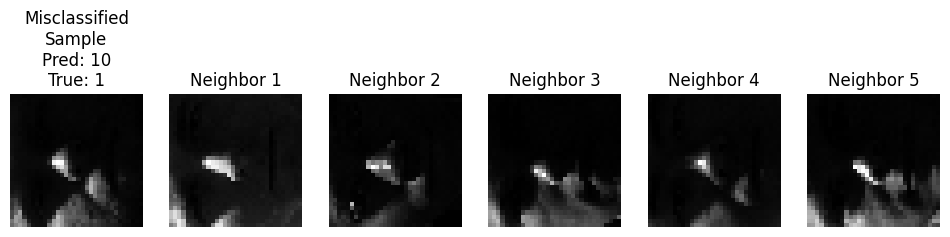

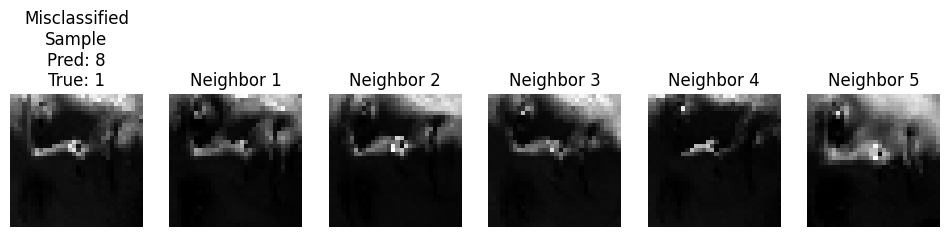

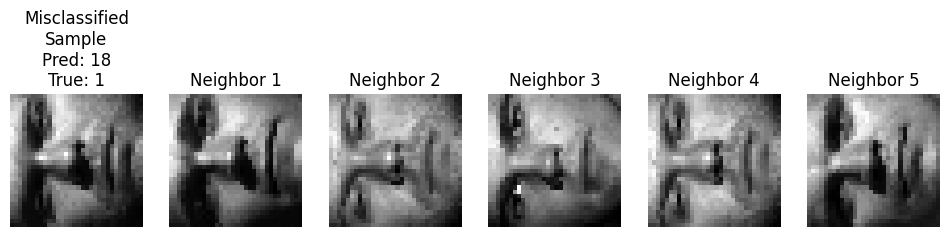

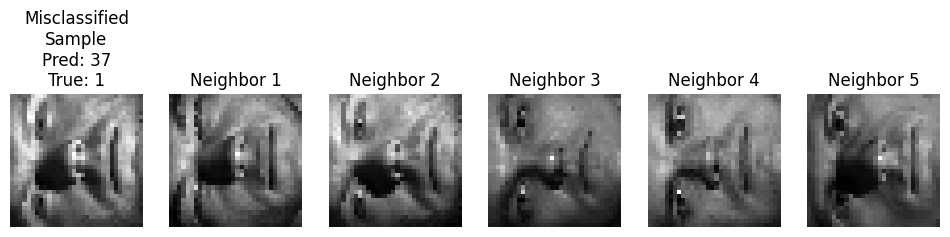

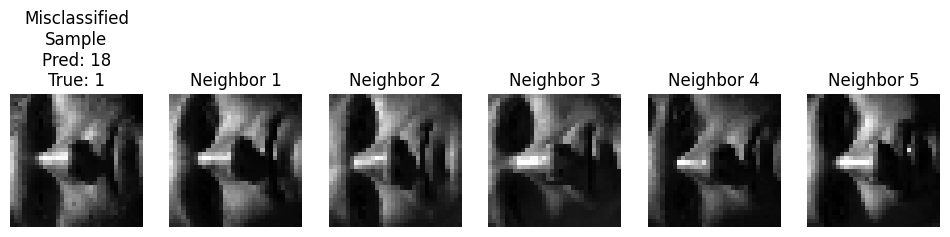

In [6]:
#Plotting the nearest neighbors for some misclassified images

np.random.seed(0)

train = []
test = []
for i in range(1,39):
    indices = np.where(data['gnd'] == i)[0]
    np.random.shuffle(indices)
    train.extend(indices[:30])
    test.extend(indices[30:])
train = np.array(train)
test = np.array(test)

X_train = data['fea'][train]
X_test = data['fea'][test]
Y_train = data['gnd'][train].ravel()
Y_test = data['gnd'][test].ravel()

# KNN
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
error = (1 - accuracy)*100
print('Error: ', error)


misclassified_indices = np.where(Y_pred != Y_test)[0]
misclassified_samples = X_test[misclassified_indices]
k = 5  # Number of neighbors to find
num_samples_to_plot = min(5, len(misclassified_indices))  # Limiting to 5 samples for brevity

for i in range(num_samples_to_plot):
    index = misclassified_indices[i]
    sample = misclassified_samples[i].reshape(32, 32)  # Reshaping to 2D image
    _, neighbors_indices = knn.kneighbors([X_test[index]], n_neighbors=k)
    neighbors_images = X_train[neighbors_indices[0]].reshape(-1, 32, 32)  # Reshaping neighbors to 2D images

    # Plotting
    plt.figure(figsize=(2*(k+1), 2))
    plt.subplot(1, k+1, 1)
    plt.imshow(sample, cmap='gray')
    plt.title(f"Misclassified\nSample\nPred: {Y_pred[index]}\nTrue: {Y_test[index]}")    
    plt.axis('off')
    
    for j in range(k):
        plt.subplot(1, k+1, j+2)
        plt.imshow(neighbors_images[j], cmap='gray')
        plt.title(f"Neighbor {j+1}")
        plt.axis('off')
    plt.show()

#### 3. Finding the best distance metric

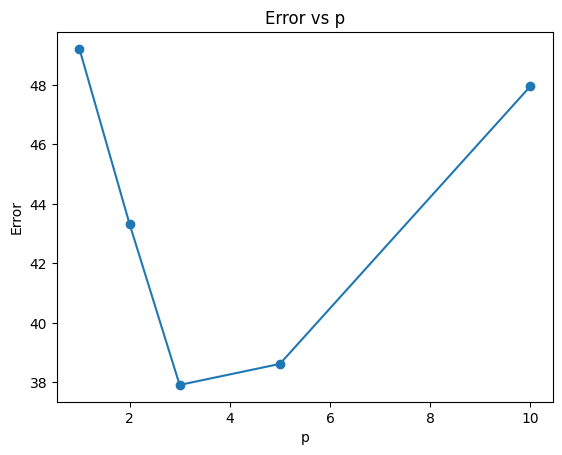

In [7]:
k = 3
m = 30
minowski = [1,2,3,5,10]

train = []
test = []

for i in range(1,39):
    indices = np.where(data['gnd'] == i)[0]
    np.random.shuffle(indices)
    train.extend(indices[:m])
    test.extend(indices[m:])
train = np.array(train)
test = np.array(test)

X_train = data['fea'][train]
X_test = data['fea'][test]
Y_train = data['gnd'][train].ravel()
Y_test = data['gnd'][test].ravel()


# KNN
errors_minowski = []
for p in minowski:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accuracy = np.mean(Y_pred == Y_test)
    error = (1 - accuracy)*100
    errors_minowski.append(error)

#Plotting the error
plt.plot(minowski, errors_minowski, 'o-')
plt.xlabel('p')
plt.ylabel('Error')
plt.title('Error vs p')
plt.show()

#### 4. LBP and HOG features

In [8]:
from skimage.feature import local_binary_pattern, hog
import numpy as np

# Defining function to extract LBP and HOG features
def extract_lbp_features(images, P=8, R=1, method='uniform'):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P, R, method)
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7) 
        lbp_features.append(hist)
    return np.array(lbp_features)

def extract_hog_features(images):
    hog_features = []
    for img in images:
        hog_desc = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
        hog_features.append(hog_desc)
    return np.array(hog_features)

images = data['fea'].reshape(-1, 32, 32).astype('float32')
labels = data['gnd'].flatten()

# Extracting LBP, HOG and Intensity features
lbp_features = extract_lbp_features(images)
hog_features = extract_hog_features(images)
intensity_features = images.reshape(images.shape[0], -1)

c:\Users\Vishantan\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


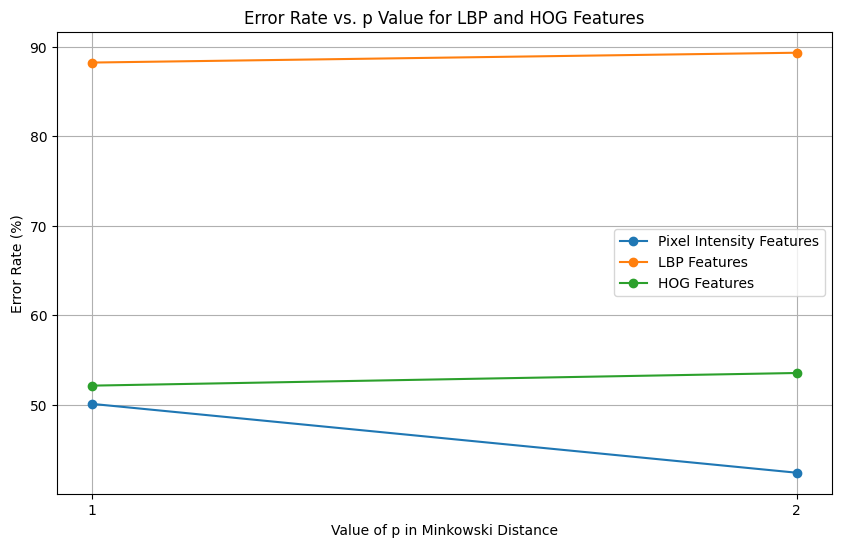

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Parameters
n_neighbors = 3
num_training_samples_per_label = 30
p_values = [1, 2]  # Minkowski distance parameters
errors_lbp = []
errors_hog = []
errors_intensity = []


def create_train_test_split(features, labels, num_samples_per_label):
    train_indices = []
    test_indices = []
    for label in np.unique(labels):
        indices = np.where(labels == label)[0]
        np.random.shuffle(indices)
        train_indices.extend(indices[:num_samples_per_label])
        test_indices.extend(indices[num_samples_per_label:])
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    return X_train, X_test, y_train, y_test

for p in p_values:

    # Pixel Intensity
    X_train_pixels, X_test_pixels, y_train_pixels, y_test_pixels = create_train_test_split(intensity_features, labels, num_training_samples_per_label)
    knn_pixels = KNeighborsClassifier(n_neighbors=n_neighbors, metric='minkowski', p=p)
    knn_pixels.fit(X_train_pixels, y_train_pixels)
    y_pred_pixels = knn_pixels.predict(X_test_pixels)
    error_pixels = (1 - accuracy_score(y_test_pixels, y_pred_pixels)) * 100
    errors_intensity.append(error_pixels)

    # LBP features
    X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = create_train_test_split(lbp_features, labels, num_training_samples_per_label)
    knn_lbp = KNeighborsClassifier(n_neighbors=n_neighbors, metric='minkowski', p=p)
    knn_lbp.fit(X_train_lbp, y_train_lbp)
    y_pred_lbp = knn_lbp.predict(X_test_lbp)
    error_lbp = (1 - accuracy_score(y_test_lbp, y_pred_lbp)) * 100
    errors_lbp.append(error_lbp)
    
    # HOG features
    X_train_hog, X_test_hog, y_train_hog, y_test_hog = create_train_test_split(hog_features, labels, num_training_samples_per_label)
    knn_hog = KNeighborsClassifier(n_neighbors=n_neighbors, metric='minkowski', p=p)
    knn_hog.fit(X_train_hog, y_train_hog)
    y_pred_hog = knn_hog.predict(X_test_hog)
    error_hog = (1 - accuracy_score(y_test_hog, y_pred_hog)) * 100
    errors_hog.append(error_hog)

# Plotting the error vs p value for LBP, HOG and Intensity
plt.figure(figsize=(10, 6))
plt.plot(p_values, errors_intensity, label='Pixel Intensity Features', marker='o')
plt.plot(p_values, errors_lbp, label='LBP Features', marker='o')
plt.plot(p_values, errors_hog, label='HOG Features', marker='o')
plt.xlabel('Value of p in Minkowski Distance')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate vs. p Value for LBP and HOG Features')
plt.xticks(p_values)
plt.legend()
plt.grid(True)
plt.show()


### **2.2 Cross Validation**

In [10]:
m = 20
train = []
test = []
for i in range(1,39):
    indices = np.where(data['gnd'] == i)[0]
    np.random.shuffle(indices)
    test.extend(indices[:m])
    train.extend(indices[m:])
train = np.array(train)
test = np.array(test)

X_train = data['fea'][train]
X_test = data['fea'][test]
Y_train = data['gnd'][train].ravel()
Y_test = data['gnd'][test].ravel()

In [11]:
# Applying 1-fold cross validation to find the best k and p

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

k_values = [1,2,3,5,10]
p_values = [1,2,3,5,10]

param_grid = {'n_neighbors': k_values, 'p': p_values}
knn = KNeighborsClassifier(metric='minkowski')

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='accuracy')

grid_search.fit(X_train, Y_train)
print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score:', grid_search.best_score_)
print('Test set score:', grid_search.score(X_test, Y_test))
print('Test Set error:', (1 - grid_search.score(X_test, Y_test))*100)

Best parameters: {'n_neighbors': 1, 'p': 5}
Best cross-validation score: 0.725509475418841
Test set score: 0.7592105263157894
Test Set error: 24.078947368421055


### **Part 3**: Other methods

#### (i) PCA

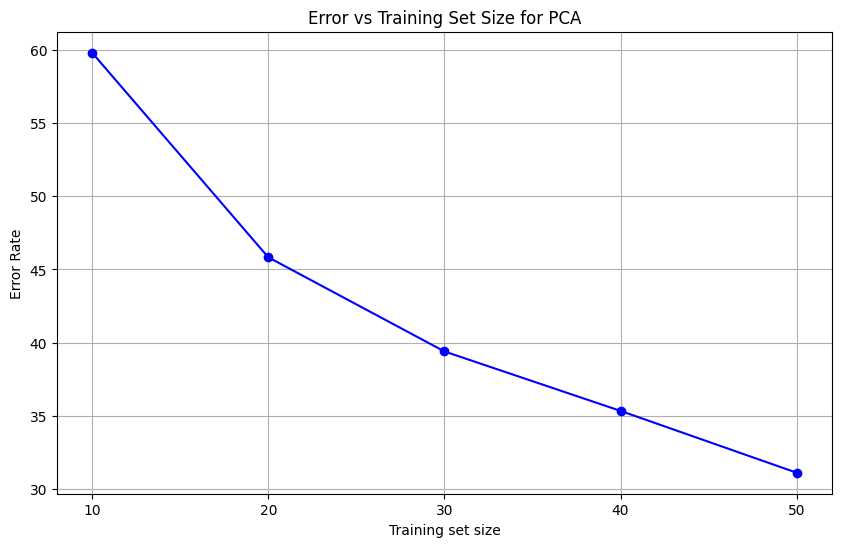

In [12]:
# Implementing PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create train-test split
splits = [10,20,30,40,50]
errors_splits_pca = []

for m in splits:
    train = []
    test = []
    for i in range(1,39):
        indices = np.where(data['gnd'] == i)[0]
        np.random.shuffle(indices)
        train.extend(indices[:m])
        test.extend(indices[m:])
    train = np.array(train)
    test = np.array(test)

    X_train = data['fea'][train]
    X_test = data['fea'][test]
    Y_train = data['gnd'][train].ravel()
    Y_test = data['gnd'][test].ravel()

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_train_pca, Y_train)
    Y_pred = knn.predict(X_test_pca)
    accuracy = np.mean(Y_pred == Y_test)
    error = (1 - accuracy)*100
    errors_splits_pca.append(error)

#Plotting the error
plt.figure(figsize=(10, 6))
plt.plot(splits, errors_splits_pca, marker='o', linestyle='-', color='b')
plt.title('Error vs Training Set Size for PCA')
plt.xlabel('Training set size')
plt.ylabel('Error Rate')
plt.xticks(splits)
plt.grid(True)
plt.show()



#### (ii) LDA

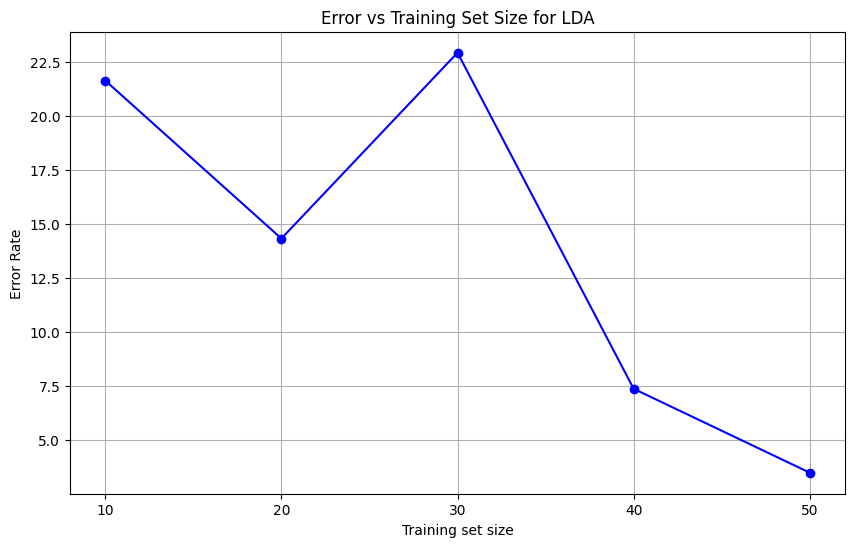

In [13]:
# Implementing LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Create train-test split
splits = [10,20,30,40,50]
errors_splits_lda = []

for m in splits:
    train = []
    test = []
    for i in range(1,39):
        indices = np.where(data['gnd'] == i)[0]
        np.random.shuffle(indices)
        train.extend(indices[:m])
        test.extend(indices[m:])
    train = np.array(train)
    test = np.array(test)

    X_train = data['fea'][train]
    X_test = data['fea'][test]
    Y_train = data['gnd'][train].ravel()
    Y_test = data['gnd'][test].ravel()

    # Apply LDA
    lda = LDA()
    X_train_lda = lda.fit_transform(X_train, Y_train)
    X_test_lda = lda.transform(X_test)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_train_lda, Y_train)
    Y_pred = knn.predict(X_test_lda)
    accuracy = np.mean(Y_pred == Y_test)
    error = (1 - accuracy)*100
    errors_splits_lda.append(error)

#Plotting the error
plt.figure(figsize=(10, 6))
plt.plot(splits, errors_splits_lda, marker='o', linestyle='-', color='b')
plt.title('Error vs Training Set Size for LDA')
plt.xlabel('Training set size')
plt.ylabel('Error Rate')
plt.xticks(splits)
plt.grid(True)
plt.show()

#### (iii) SVM

Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.5473684210526316
Test set score: 0.6406096361848574
Test Set error: 35.939036381514256
Best parameters: {'C': 100, 'gamma': 0.001}
Best cross-validation score: 0.7710526315789474
Test set score: 0.8143893591293833
Test Set error: 18.561064087061673
Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.8333333333333334
Test set score: 0.8979591836734694
Test Set error: 10.204081632653061
Best parameters: {'C': 100, 'gamma': 0.001}
Best cross-validation score: 0.8881578947368421
Test set score: 0.9183445190156599
Test Set error: 8.165548098434005
Best parameters: {'C': 10, 'gamma': 0.001}
Best cross-validation score: 0.9247368421052631
Test set score: 0.9416342412451362
Test Set error: 5.836575875486383


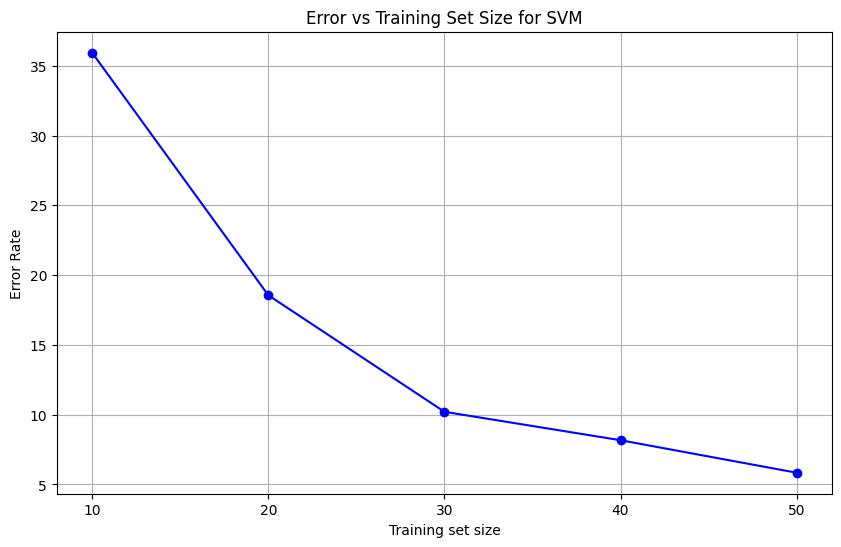

In [14]:
# Implementing SVM

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Create train-test split
splits = [10,20,30,40,50]
errors_splits_svm = []

for m in splits:
    train = []
    test = []
    for i in range(1,39):
        indices = np.where(data['gnd'] == i)[0]
        np.random.shuffle(indices)
        train.extend(indices[:m])
        test.extend(indices[m:])
    train = np.array(train)
    test = np.array(test)

    X_train = data['fea'][train]
    X_test = data['fea'][test]
    Y_train = data['gnd'][train].ravel()
    Y_test = data['gnd'][test].ravel()

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SVM
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train_scaled, Y_train)
    print('Best parameters:', grid_search.best_params_)
    print('Best cross-validation score:', grid_search.best_score_)
    print('Test set score:', grid_search.score(X_test_scaled, Y_test))
    print('Test Set error:', (1 - grid_search.score(X_test_scaled, Y_test))*100)
    errors_splits_svm.append((1 - grid_search.score(X_test_scaled, Y_test))*100)

#Plotting the error
plt.figure(figsize=(10, 6))
plt.plot(splits, errors_splits_svm, marker='o', linestyle='-', color='b')
plt.title('Error vs Training Set Size for SVM')
plt.xlabel('Training set size')
plt.ylabel('Error Rate')
plt.xticks(splits)
plt.grid(True)
plt.show()


#### (iv) SRC

c:\Users\Vishantan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\Vishantan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a Stan

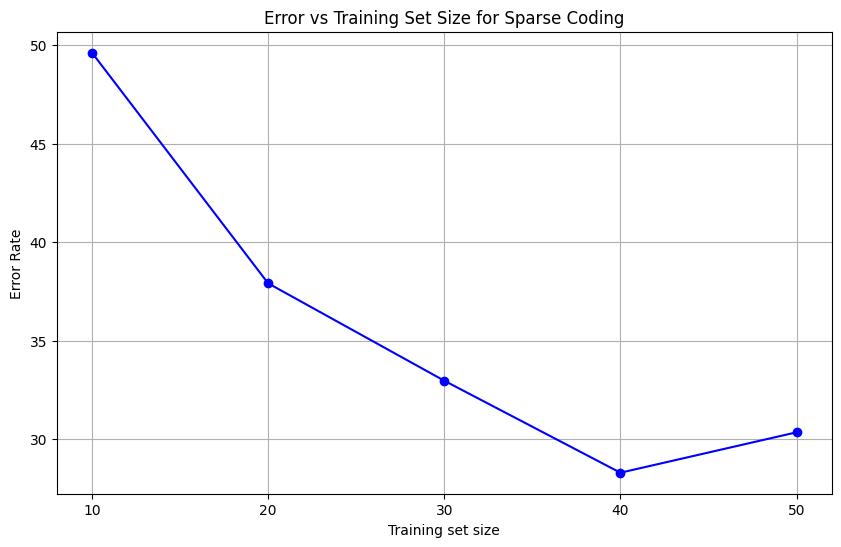

In [15]:
#Implementing SRC

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


def omp_predict(train_data, train_labels, test_data, n_nonzero_coefs):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    omp.fit(train_data, train_labels)
    selected_features = omp.coef_ != 0
    
    # Using KNN for classification based on the features selected by OMP
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_data[:, selected_features], train_labels)
    predictions = knn.predict(test_data[:, selected_features])
    
    return predictions

# Create train-test split
splits = [10,20,30,40,50]
errors_splits_src = []

for m in splits:
    train = []
    test = []
    for i in range(1,39):
        indices = np.where(data['gnd'] == i)[0]
        np.random.shuffle(indices)
        train.extend(indices[:m])
        test.extend(indices[m:])
    train = np.array(train)
    test = np.array(test)

    X_train = data['fea'][train]
    X_test = data['fea'][test]
    Y_train = data['gnd'][train].ravel()
    Y_test = data['gnd'][test].ravel()

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    predictions = omp_predict(X_train_scaled, Y_train, X_test_scaled, 35)  # n_nonzero_coefs is a hyperparameter
    accuracy = accuracy_score(Y_test, predictions)
    error_rate = (1 - accuracy) * 100
    errors_splits_src.append(error_rate)

plt.figure(figsize=(10, 6))
plt.plot(splits, errors_splits_src, marker='o', linestyle='-', color='b')
plt.title('Error vs Training Set Size for Sparse Coding')
plt.xlabel('Training set size')
plt.ylabel('Error Rate')
plt.xticks(splits)
plt.grid(True)
plt.show()


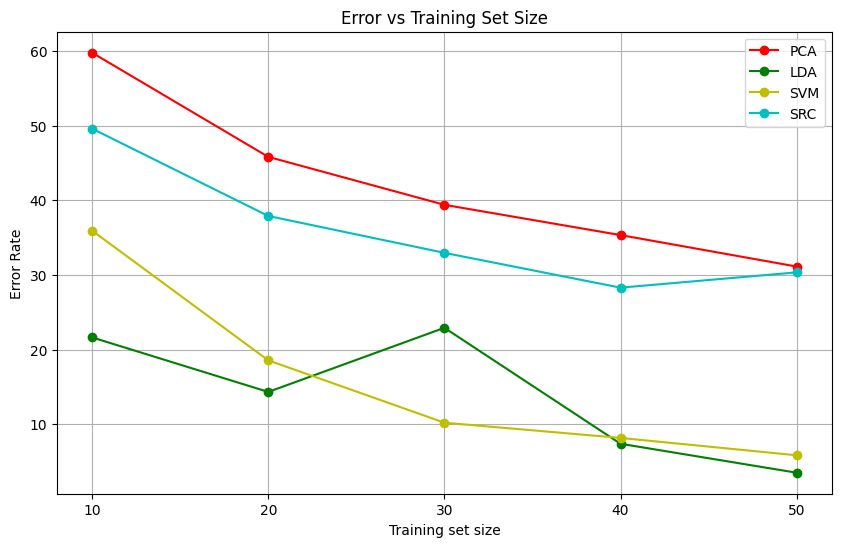

In [16]:
#Plotting all the errors together
plt.figure(figsize=(10, 6))

plt.plot(splits, errors_splits_pca, marker='o', linestyle='-', color='r', label='PCA')
plt.plot(splits, errors_splits_lda, marker='o', linestyle='-', color='g', label='LDA')
plt.plot(splits, errors_splits_svm, marker='o', linestyle='-', color='y', label='SVM')
plt.plot(splits, errors_splits_src, marker='o', linestyle='-', color='c', label='SRC')
plt.title('Error vs Training Set Size')
plt.xlabel('Training set size')
plt.ylabel('Error Rate')
plt.xticks(splits)
plt.legend()
plt.grid(True)
plt.show()
